In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the data
ppi_clean = pd.read_csv('data/ppi_clean.csv')
ppi_clean

,domain,aa_ProtPosition,uniprot_id,hydrophobicity_scores,Rlength,normalized_length,normalized_abs_surf_acc,normalized_hydropathy_index,rel_surf_acc,prob_sheet,...,9_wm_pssm_K,9_wm_pssm_M,9_wm_pssm_F,9_wm_pssm_P,9_wm_pssm_S,9_wm_pssm_T,9_wm_pssm_W,9_wm_pssm_Y,9_wm_pssm_V,p_interface
0,0,1,A0A024RAV5,0.64,188,0.238095,0.784319,0.711111,0.803,0.003,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
1,0,2,A0A024RAV5,-0.05,188,0.238095,0.359207,0.422222,0.530,0.047,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
2,0,3,A0A024RAV5,-0.74,188,0.238095,0.395387,0.111111,0.464,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
3,0,4,A0A024RAV5,0.26,188,0.238095,0.401655,0.355556,0.385,0.084,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
4,1,5,A0A024RAV5,-1.50,188,0.238095,0.288103,0.066667,0.287,0.084,...,0.302858,0.436017,0.238759,0.103980,0.105653,0.161544,0.060391,0.140326,0.481904,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65145,1,34,P0A427,1.38,38,0.014881,0.210794,1.000000,0.233,0.086,...,0.286923,0.374128,0.415754,0.109332,0.351726,0.330383,0.241807,0.334863,0.381730,1
65146,0,35,P0A427,-0.74,38,0.014881,0.292872,0.111111,0.343,0.086,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
65147,0,36,P0A427,0.48,38,0.014881,0.141193,0.455556,0.367,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
65148,0,37,P0A427,-0.74,38,0.014881,0.406473,0.111111,0.477,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1


In [13]:
# Remove columns that shouldn't be features
def remove_non_features(df: pd.DataFrame, non_feature_cols: list[str]) -> pd.DataFrame:
    return df.drop(non_feature_cols, axis=1)

In [16]:
# Split data into train/validation and test set, taking into account the protein groups
from sklearn.model_selection import GroupShuffleSplit

def split_data_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, **kwargs) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    gss = GroupShuffleSplit(**kwargs)

    for train_idx, test_idx in gss.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    assert set(X_train.uniprot_id).intersection(set(X_test.uniprot_id)) == set(), 'The same uniprot ID appears in both the train and test set!'
    return X_train, X_test, y_train, y_test

def select_window_size(df: pd.DataFrame, window_size: int) -> pd.DataFrame:
    '''Remove the window columns that are not used, i.e. not specified in window_size'''
    wm_cols = df.columns[df.columns.str.match(r"^\d+_wm")].tolist()  # Regex for [number]_wm
    pssm_cols = [col for col in df.columns if col.startswith('pssm') or col.startswith('prob')]
    extra_cols = ['rel_surf_acc', 'normalized_abs_surf_acc', 'normalized_hydropathy_index']
    all_cols = set(wm_cols + pssm_cols + extra_cols)
    if window_size != 1:
        keep_cols = set([col for col in df.columns if col.startswith(f"{window_size}_wm")])
        cols_to_remove = list(set(all_cols).difference(set(keep_cols)))

    else:
        cols_to_remove = wm_cols
    cols_before = frozenset(df.columns)
    df = df.drop(cols_to_remove, axis=1)
    cols_after = frozenset(df.columns)
    print('Intersection: ', cols_before.intersection(cols_after))

    return df

ppi_clean_9 = select_window_size(ppi_clean, 9)

X = ppi_clean_9.drop('p_interface', axis=1)
y = ppi_clean_9.p_interface
groups = ppi_clean.uniprot_id

X_tv, X_test, y_tv, y_test = split_data_by_group(X, y, groups, train_size=0.2)

Intersection:  frozenset({'9_wm_prob_helix', '9_wm_pssm_Q', '9_wm_pssm_C', '9_wm_pssm_E', '9_wm_pssm_P', '9_wm_pssm_V', '9_wm_pssm_F', '9_wm_prob_sheet', 'domain', '9_wm_pssm_M', 'hydrophobicity_scores', '9_wm_normalized_hydropathy_index', '9_wm_pssm_K', 'aa_ProtPosition', '9_wm_normalized_abs_surf_acc', '9_wm_pssm_L', '9_wm_pssm_S', 'Rlength', '9_wm_pssm_D', '9_wm_pssm_R', '9_wm_pssm_H', '9_wm_pssm_W', '9_wm_pssm_I', 'p_interface', '9_wm_pssm_Y', 'uniprot_id', '9_wm_pssm_G', '9_wm_rel_surf_acc', '9_wm_prob_coil', '9_wm_pssm_A', '9_wm_pssm_T', '9_wm_pssm_N', 'normalized_length'})


Performing on fold=0
len(train_idx)=10096, len(val_idx)=2512
Performing on fold=1
len(train_idx)=10095, len(val_idx)=2513
Performing on fold=2
len(train_idx)=10069, len(val_idx)=2539
Performing on fold=3
len(train_idx)=10087, len(val_idx)=2521
Performing on fold=4
len(train_idx)=10085, len(val_idx)=2523


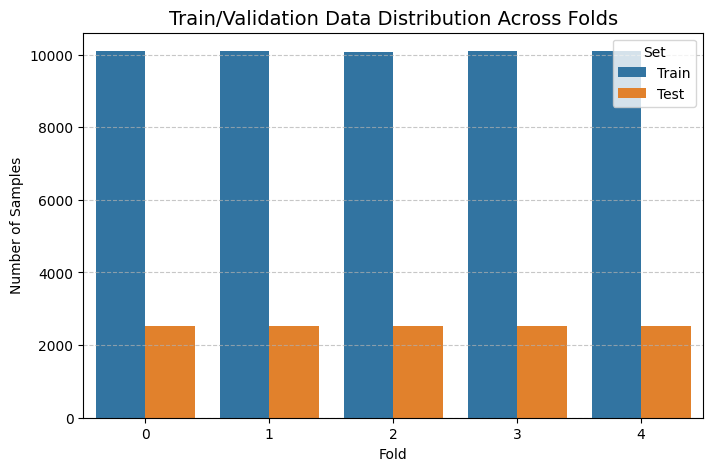

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, recall_score

def kfold_cv_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, model: BaseEstimator, **kwargs) -> pd.DataFrame:
    group_kfold = GroupKFold(**kwargs)

    scores = {'fold': [], 'auc': [], 'rec': []}
    fold_data = {'Fold': [], 'Set': [], 'Size': []}

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups)):
        print(f'Performing on {fold=}')
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        auc_score = roc_auc_score(y_val, y_pred)
        rec_score = recall_score(y_val, y_pred)
        
        scores['fold'].append(fold)
        scores['auc'].append(auc_score)
        scores['rec'].append(rec_score)  # TPR

        fold_data['Fold'].extend([fold, fold])  # Add fold index twice
        fold_data['Set'].extend(["Train", "Test"])  # Train and Test labels
        fold_data['Size'].extend([len(train_idx), len(val_idx)])  # Number of samples
        print(f'{len(train_idx)=}, {len(val_idx)=}')
    
    # Convert to DataFrame
    fold_df = pd.DataFrame(fold_data)

    # Create bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=fold_df, x="Fold", y="Size", hue="Set")

    # Customize plot
    plt.title("Train/Validation Data Distribution Across Folds", fontsize=14)
    plt.xlabel("Fold")
    plt.ylabel("Number of Samples")
    plt.legend(title="Set", loc="upper right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return pd.DataFrame(scores)

non_feature_cols = ['domain', 'aa_ProtPosition', 'uniprot_id']
X = remove_non_features(X_tv, non_feature_cols)
y = y_tv
groups = X_tv.uniprot_id

baseline_model = DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=12)

baseline_scores = kfold_cv_by_group(X, y, groups, baseline_model)

  Metric     Score      Mean     StDev
0    auc  0.515523  0.527448  0.043947
1    auc  0.566775  0.527448  0.043947
2    auc  0.500722  0.527448  0.043947
3    auc  0.475524  0.527448  0.043947
4    auc  0.578695  0.527448  0.043947
5    rec  0.485075  0.562855  0.148217
6    rec  0.593640  0.562855  0.148217
7    rec  0.503778  0.562855  0.148217
8    rec  0.805310  0.562855  0.148217
9    rec  0.426471  0.562855  0.148217


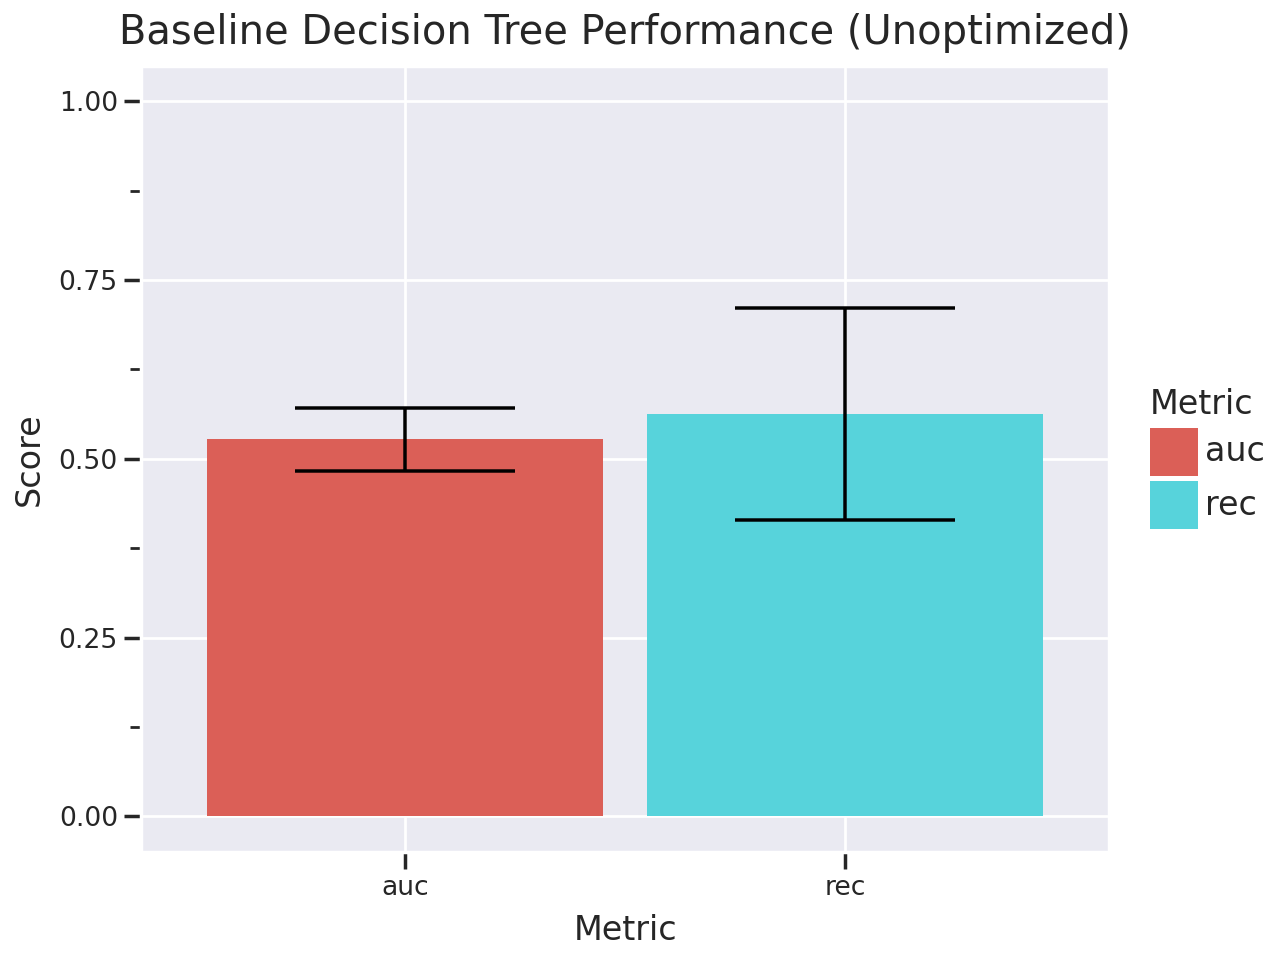

In [84]:
from plotnine import ggplot, aes, geom_bar, geom_errorbar, labs, theme_seaborn, ylim

baseline_scores_long = baseline_scores.melt(value_vars=['auc', 'rec'], var_name='Metric', value_name='Score')
score_means = baseline_scores[['auc', 'rec']].mean()
score_stds = baseline_scores[['auc', 'rec']].std()
score_summary = pd.DataFrame({
    'Metric': score_means.index,
    'Mean': score_means.values,
    'StDev': score_stds.values
})
baseline_scores_long = baseline_scores_long.merge(score_summary, on='Metric', how='left')

print(baseline_scores_long)

# Create ggplot
p = (
    ggplot(baseline_scores_long, aes(x='Metric', y='Mean', fill='Metric')) +
    geom_bar(stat='identity', position='dodge', show_legend=True) +  # Bar plot
    labs(title='Baseline Decision Tree Performance (Unoptimized)', y="Score", x="Metric") +
    geom_errorbar(aes(ymin='Mean - StDev', ymax='Mean + StDev')) +
    ylim(0,1) +
    theme_seaborn()
)

p